In [1]:
import numpy as np
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as a3d
%matplotlib inline

In [2]:
b_norms = np.asarray(
  [[-1.0, 0.0, 0.0],
  [0.0, -1.0, 0.0],
  [-0.347252784,  -0.782219564,	0.517250479],
  [0.393457551, 0.541547875,	0.742911202],
  [0.636627669,0.206852872,	-0.742911233],
  [0.347252811,0.782219525,	-0.517250519],
  [0.851239679,-0.502239228,	0.152140616],
  [0.740705521,-0.654376459,	-0.152140661],
  [0.347250266,-0.112828417,	0.930960257],
  [0.214610424,0.96477748,	-0.152140661],
  [0.214612459,-0.295388659,	-0.930960274],
  [0.740710551,0.428718814,	0.517250479],
  [0.74071057,-0.428718733,	-0.517250519],
  [0.214612457,0.295388714,	0.930960257],
  [0.636627941,0.571976193,	-0.517250519],
  [0.393458463,0.90666624,	0.152140616],
  [-8.47266E-09,0.365120484,	-0.930960274],
  [4.65998E-08,-0.66938998,	0.742911202],
  [0.851239626,0.502239303,	-0.152140661],
  [0.636628012,-0.57197615,	0.517250479],
  [0.347250215,	0.112828436,	-0.930960274],
  [0.636627721,	-0.206852824,	0.742911202],
  [0.740705466,	0.654376532,	0.152140616],
  [0.347252893,	-0.782219515,	0.517250479],
  [0.393458544,	-0.906666197,	-0.152140661],
  [0.983876179,	0.094025976,	-0.152140661],
  [0.214610515,	-0.964777466,	0.152140616],
  [0.983876194,	-0.094025886,	0.152140616],
  [0.178843722,	-0.836938961,	-0.517250519],
  [0.851242003,	-0.088537859,	-0.517250519],
  [0.851242019,	0.08853794,	0.517250479],
  [-0.983876181,	-0.094026023,	0.152140616],
  [-0.214610381,	-0.964777496,	0.152140616],
  [-0.983876183,	0.094025931,	-0.152140661],
  [-0.178843606,	-0.836938985,	-0.517250519],
  [-0.851241991,	-0.088537977,	-0.517250519],
  [-0.34725022,	0.11282842,	-0.930960274],
  [2.5418E-08,	-0.365120527,	0.930960257],
  [-0.740705496,	0.654376498,	0.152140616],
  [-0.393458418,	-0.906666252,	-0.152140661],
  [-1.55333E-08,	0.669389946,	-0.742911233],
  [-0.740710511,	-0.428718836,	-0.517250519],
  [-0.636627932,	-0.571976239,	0.517250479],
  [-0.85123965,	0.502239263,	-0.152140661],
  [-0.393457505,	-0.541547866,	-0.742911233],
  [-0.636627692,	-0.206852912,	0.742911202],
  [-0.214612471,	0.295388704,	0.930960257],
  [-0.636627968,	0.571976163,	-0.517250519],
  [-0.740710571,	0.428718779,	0.517250479],
  [-0.393458505,	0.906666222,	0.152140616],
  [-0.851239609,	-0.502239346,	0.152140616],
  [-0.34725025,	-0.112828466,	0.930960257],
  [-0.636627678,	0.206852842,	-0.742911233],
  [-0.74070543,	-0.654376562,	-0.152140661],
  [-0.214612418,	-0.295388689,	-0.930960274],
  [-0.851242023,	0.088537901,	0.517250479],
  [-0.178843689,	0.836938992,	0.517250479],
  [-0.214610469,	0.96477747,	-0.152140661],
  [-0.393457576,	0.541547857,	0.742911202],
  [-0.347252847,	0.782219509,	-0.517250519]]
)


In [3]:
r = np.sqrt(np.sum(b_norms**2, axis=1))
theta = np.arctan2(np.sqrt(b_norms[:, 0]**2 + b_norms[:, 1]**2), b_norms[:, 2])
phi = np.arctan2(b_norms[:, 1], b_norms[:, 0])

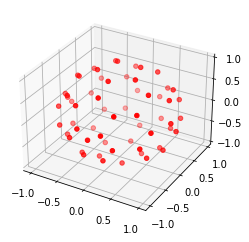

In [4]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(b_norms[:, 0], b_norms[:, 1], b_norms[:, 2], color='r', s=20)

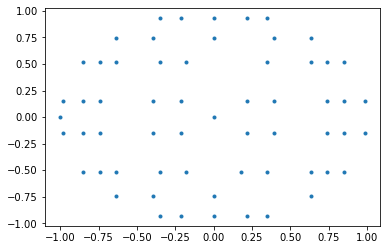

In [7]:
n_rays = 100
radius = 1
n_rings = 10

nrays_r = np.round((2 * nrays * n_rings) / n_rings)


dr = radius / num_rings
ds = 2 * np.pi * radius 